<a href="https://colab.research.google.com/github/Datasci266-Final-Project/Job-Listings/blob/main/Analysis%20Notebooks/Model_1_Testing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install transformers==4.37.2 --quiet
!pip install -U imbalanced-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
#@title Imports
import pandas as pd

import numpy as np
import random
import torch

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import re
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFXLMRobertaModel #"FacebookAI/xlm-roberta-base"

from transformers import logging
logging.set_verbosity_error()

In [ ]:
# Set seed to 10

seed_value = 10

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/DataSci 266 Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1V3QooLePiHR_DaZhbXQhsjmP1Ez5fv5F/DataSci 266 Project


In [ ]:
# Dictionaries
level_key = {
    "student_intern": 0,
    "entry": 1,
    "junior": 2,
    "mid": 3,
    "senior": 4,
    "executive": 5,
    np.nan: -1
}

# Define salary_key dictionary
salary_key = {
    "<45k": 0,
    "45-65k": 1,
    "65-85k": 2,
    "85-110k": 3,
    "110-150k": 4,
    "150-200k": 5,
    ">200k": 6,
    np.nan: -1
}

In [ ]:
#@title Import pickle files


#import tokenized inputs for each model
with open(r'Model Objects/Tokenized Inputs: Bert Base/test_inputs_bert.pickle', 'rb') as handle:
    bert_base_test_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: Bert Multilingual/test_inputs_bert_multilingual.pickle', 'rb') as handle:
    bert_multilingual_test_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: xlm-RoBERTa/test_inputs_xlm_roberta.pickle', 'rb') as handle:
    xlm_roberta_test_inputs = pickle.load(handle)


# import data
with open(r'Model Objects/test_data.pickle', 'rb') as handle:
    test_data = pickle.load(handle)


# import labels
with open(r'Model Objects/Labels/labels_level_test_baseline.pickle', 'rb') as handle:
    test_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/labels_salary_test_baseline.pickle', 'rb') as handle:
    test_salary_labels = pickle.load(handle)






In [ ]:
MAX_SEQUENCE_LENGTH = 512

In [ ]:
#@title Define Bert Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_bert_multi_output_model(bert_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=8,
                                 base_hidden_size=100,
                                  level_hidden_size=100,
                                  salary_hidden_size=100,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    bert_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]  # Extract CLS token
    # pooler_token = bert_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_out = tf.keras.layers.Dropout(dropout)(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_out)
    level_hidden = tf.keras.layers.Dropout(dropout)(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_out)
    salary_hidden = tf.keras.layers.Dropout(dropout)(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
#@title Define xlm-roberta Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_xlm_roberta_multi_output_model(xlm_roberta_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=8,
                                 base_hidden_size=100,
                                  level_hidden_size=100,
                                  salary_hidden_size=100,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    xlm_roberta_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    xlm_roberta_inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    xlm_roberta_out = xlm_roberta_base_model(xlm_roberta_inputs)

    cls_token = xlm_roberta_out[0][:, 0, :]  # Extract CLS token
    # pooler_token = xlm_roberta_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_out = tf.keras.layers.Dropout(dropout)(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_out)
    level_hidden = tf.keras.layers.Dropout(dropout)(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_out)
    salary_hidden = tf.keras.layers.Dropout(dropout)(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
# bert base model from pre-saved weights
bert_base_model = TFBertModel.from_pretrained('bert-base-cased')
bert_base_model = create_bert_multi_output_model(bert_base_model)

bert_base_model.load_weights('./Model Objects/model_1_bert/model_1_bert_base_weights')

# bert multilingual model from pre-saved weights
bert_multilingual_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
bert_multilingual_model = create_bert_multi_output_model(bert_multilingual_model)

bert_multilingual_model.load_weights('./Model Objects/model_1_multilingual/model_1_multilingual_weights')

# xlm_roberta model from pre-saved weights
xlm_roberta_model = TFXLMRobertaModel.from_pretrained("FacebookAI/xlm-roberta-base")
xlm_roberta_model = create_xlm_roberta_multi_output_model(xlm_roberta_model)

xlm_roberta_model.load_weights('./Model Objects/model_1_xlm_roberta/model_1_xlm_roberta_weights')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# bert_base_model.evaluate(bert_base_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
# bert_multilingual_model.evaluate(bert_multilingual_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
# xlm_roberta_model.evaluate(xlm_roberta_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
#set target level names and target salary names
target_names = ["student_intern", "entry", "junior", "mid", "senior", "executive","unknown"]
target_salary_names = ["<45k",
    "45-60k",
    "65-85k",
    "85-110k",
    "110-150k",
    "150-200k",
    ">200k",
    "unknown"]




In [ ]:
predictions_bert_base = bert_base_model.predict(bert_base_test_inputs)
predictions_bert_multilingual = bert_multilingual_model.predict(bert_multilingual_test_inputs)
predictions_xlm_roberta = xlm_roberta_model.predict(xlm_roberta_test_inputs)




440/440 [==============================] - 173s 386ms/step


In [ ]:
level_predictions_bert_base = tf.argmax(predictions_bert_base[0], axis=-1)
salary_predictions_bert_base = tf.argmax(predictions_bert_base[1], axis=-1)

level_predictions_bert_multilingual = tf.argmax(predictions_bert_multilingual[0], axis=-1)
salary_predictions_bert_multilingual = tf.argmax(predictions_bert_multilingual[1], axis=-1)

level_predictions_xlm_roberta = tf.argmax(predictions_xlm_roberta[0], axis=-1)
salary_predictions_xlm_roberta = tf.argmax(predictions_xlm_roberta[1], axis=-1)


In [ ]:
test_level_labels = test_level_labels.apply(lambda x: 6 if x == -1 else x)


In [ ]:
# bert base levels confusion matrix
cm = tf.math.confusion_matrix(test_level_labels, level_predictions_bert_base)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 1: BERT Base - Level')

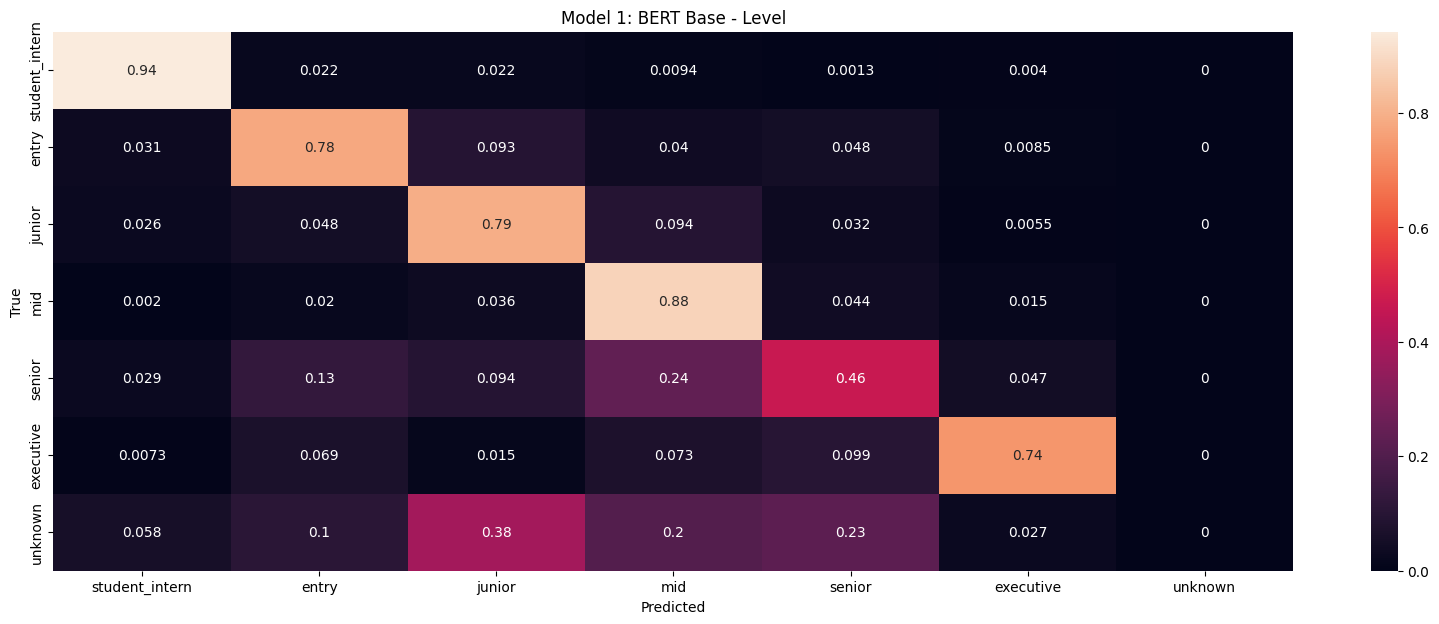

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: BERT Base - Level")

In [ ]:
test_salary_labels = test_salary_labels.apply(lambda x: 7 if x == -1 else x)

In [ ]:
cm = tf.math.confusion_matrix(test_salary_labels, salary_predictions_bert_base)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 1: BERT Base - Salary')

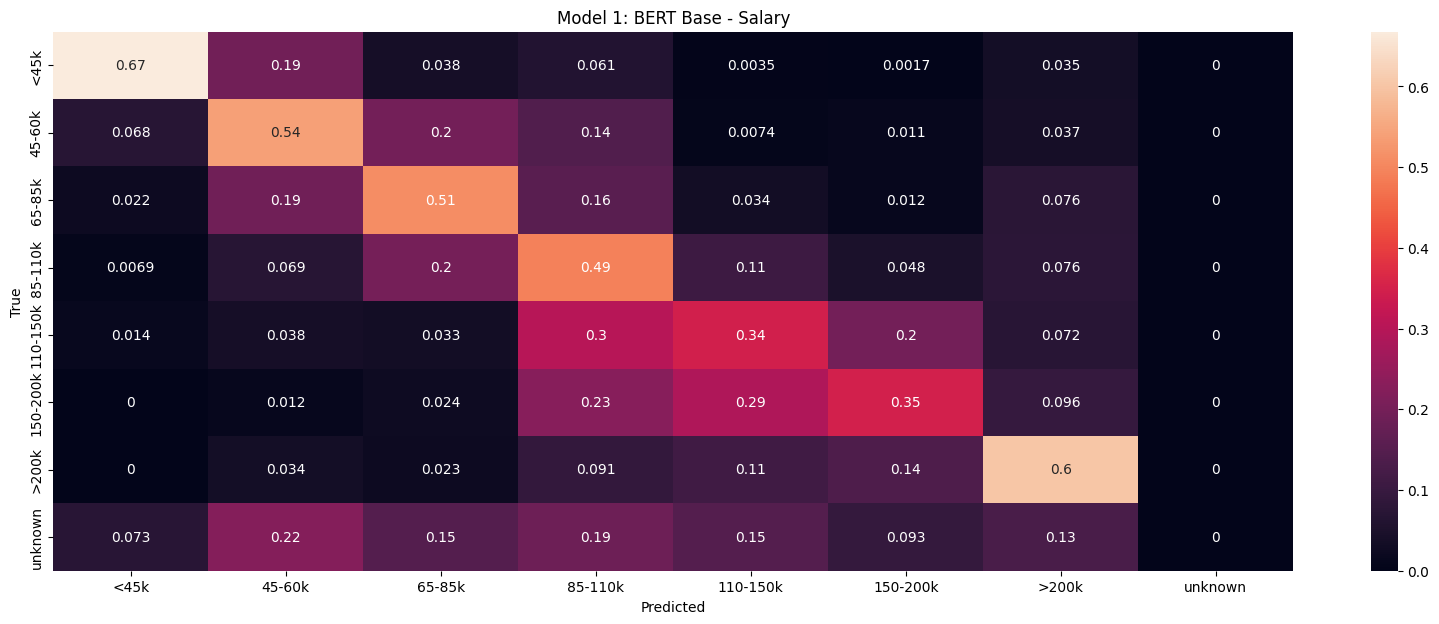

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: BERT Base - Salary")

In [ ]:
# calculate adjusted salary accuracy for bert base
print("Model 1: Bert Base Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 7)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_bert_base.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 1: Bert Base Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.08746355685131195
% Salary predictions incorrect: 0.9125364431486881
Adjusted Salary Accuracy: 0.5364151766245092


In [ ]:
# calculate adjusted level accuracy for bert base
print("Model 1: Bert Base Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_bert_base.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 1: Bert Base Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.5746995662376448
% Level predictions incorrect: 0.42530043376235516
Adjusted Level Accuracy: 0.6569663469354576


Text(0.5, 1.0, 'Model 1: BERT Multilingual - Level')

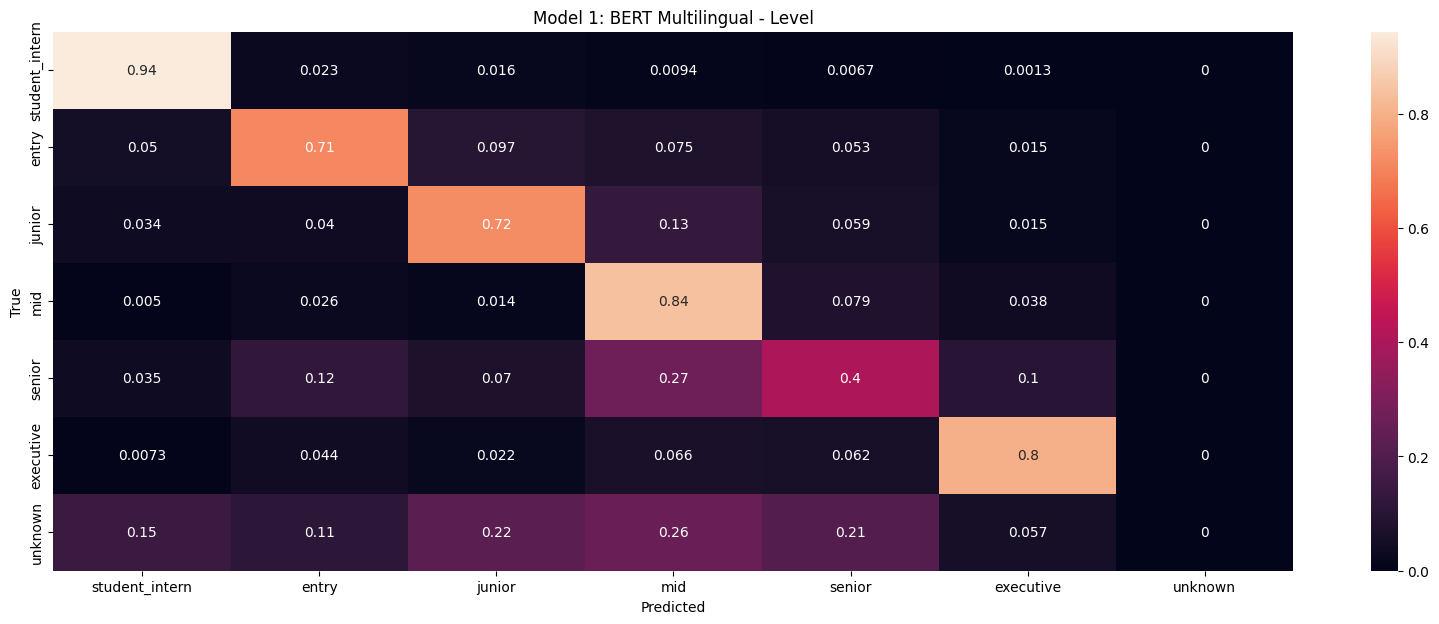

In [ ]:
# bert multilingual levels confusion matrix
cm = tf.math.confusion_matrix(test_level_labels, level_predictions_bert_multilingual)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: BERT Multilingual - Level")

Text(0.5, 1.0, 'Model 1: BERT Multilingual - Salary')

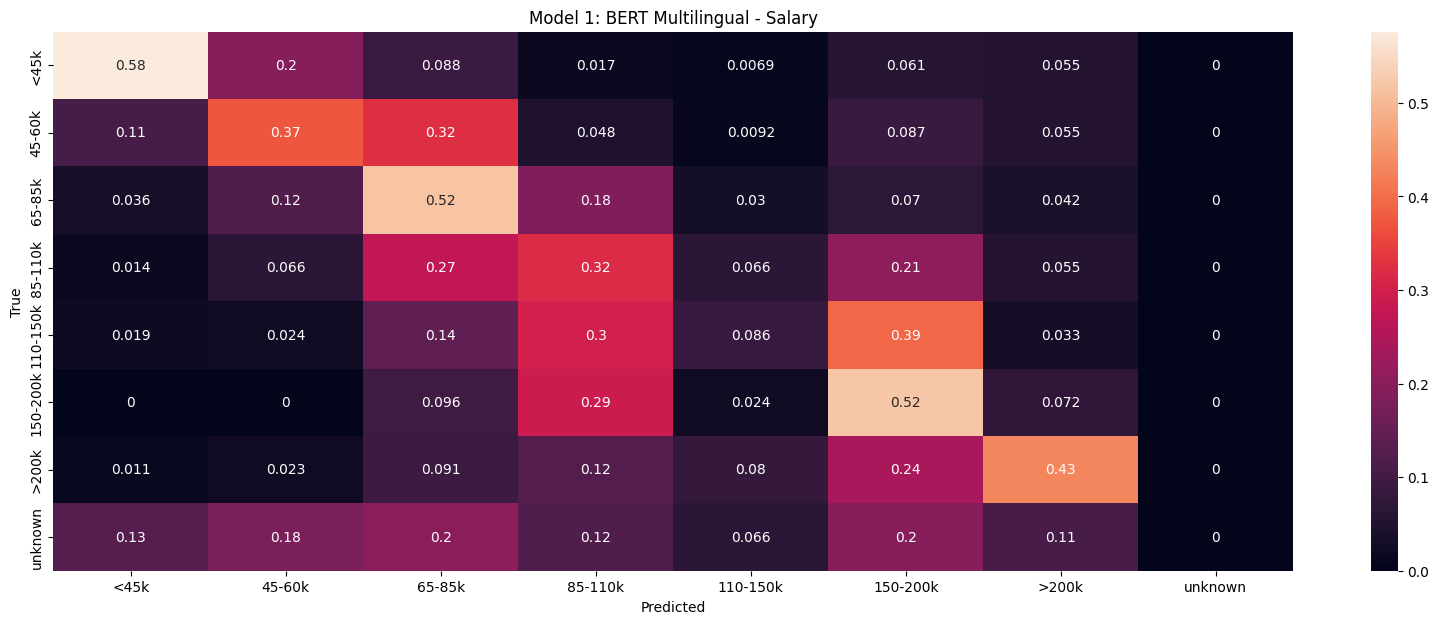

In [ ]:
cm = tf.math.confusion_matrix(test_salary_labels, salary_predictions_bert_multilingual)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: BERT Multilingual - Salary")

In [ ]:
# calculate adjusted salary accuracy for bert multilingual
print("Model 1: Bert Multilingual Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 7)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_bert_multilingual.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 1: Bert Multilingual Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.07011306264666145
% Salary predictions incorrect: 0.9298869373533385
Adjusted Salary Accuracy: 0.43000436109899715


In [ ]:
# calculate adjusted level accuracy for bert multilingual
print("Model 1: Bert Multilingual Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_bert_multilingual.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 1: Bert Multilingual Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.5273412500888858
% Level predictions incorrect: 0.47265874991111423
Adjusted Level Accuracy: 0.6028288083238498


Text(0.5, 1.0, 'Model 1: xlm-roberta - Level')

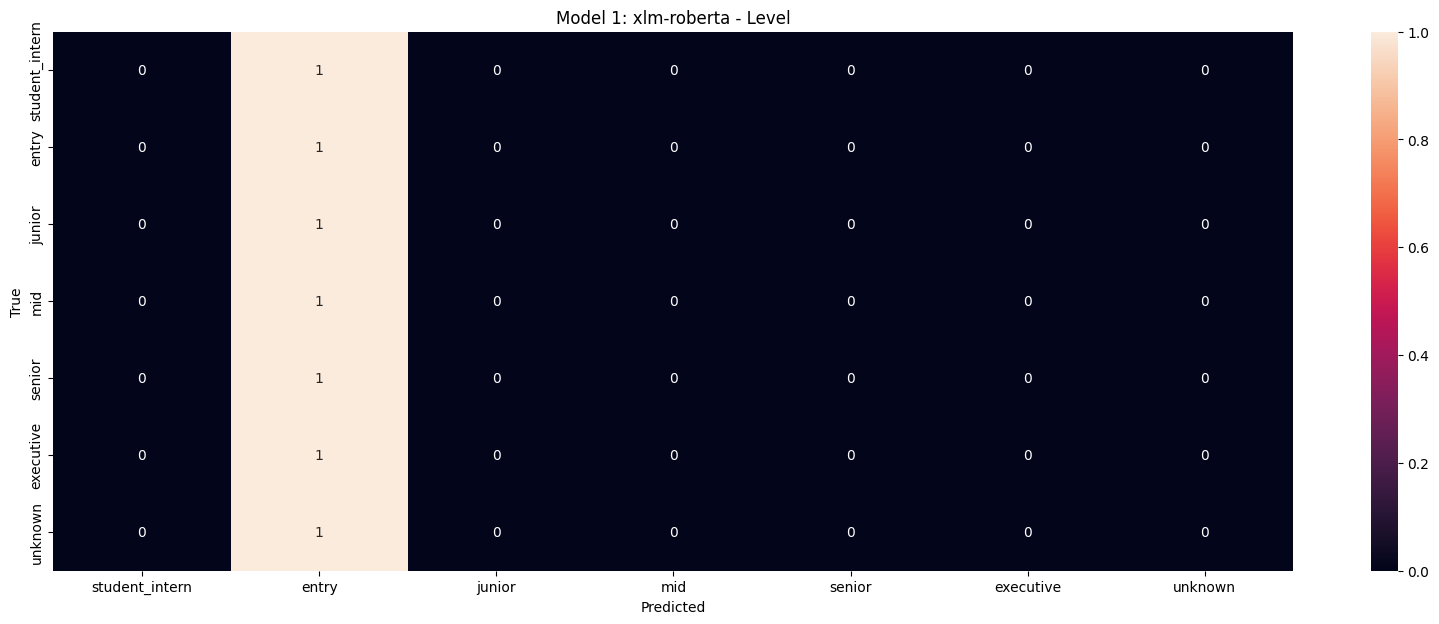

In [ ]:
# xlm-roberta levels confusion matrix
cm = tf.math.confusion_matrix(test_level_labels, level_predictions_xlm_roberta)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: xlm-roberta - Level")

Text(0.5, 1.0, 'Model 1: xlm-roberta - Salary')

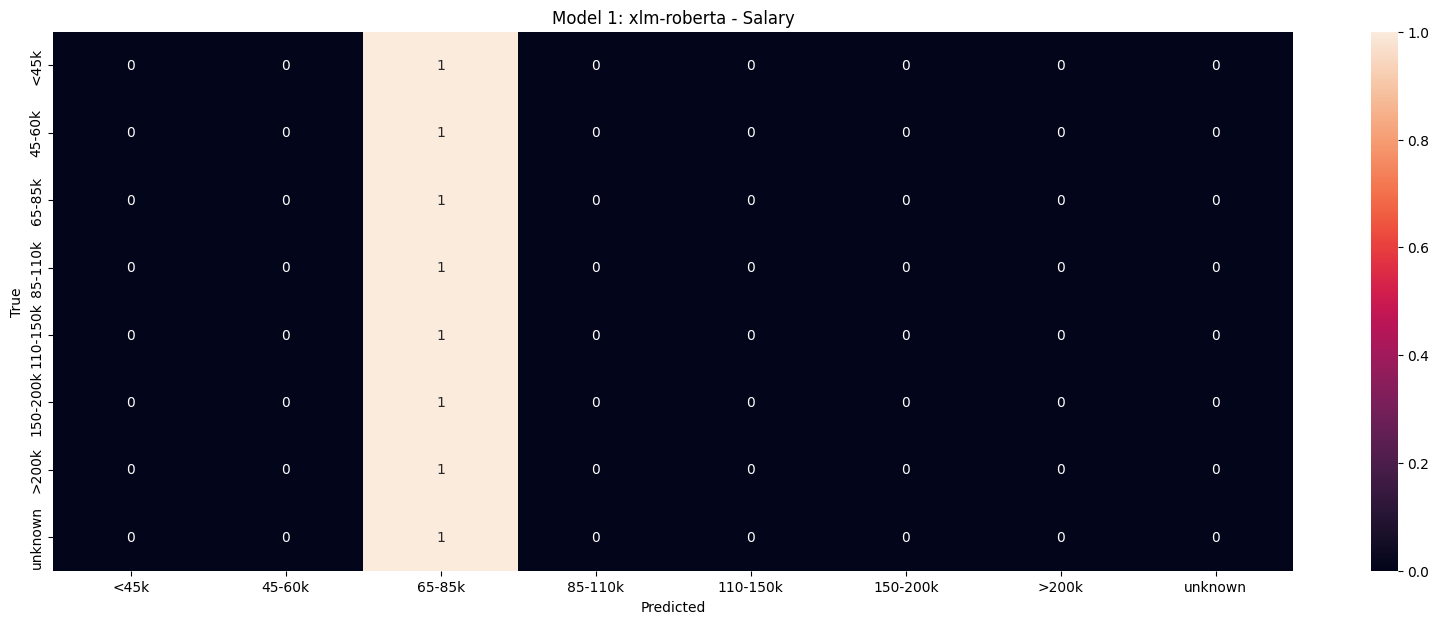

In [ ]:
cm = tf.math.confusion_matrix(test_salary_labels, salary_predictions_xlm_roberta)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 1: xlm-roberta - Salary")

In [ ]:
# calculate adjusted salary accuracy for xlm-roberta
print("Model 1: xlm-roberta Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 7)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_xlm_roberta.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 1: xlm-roberta Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.03576761715139017
% Salary predictions incorrect: 0.9642323828486098
Adjusted Salary Accuracy: 0.21936327954644577


In [ ]:
# calculate adjusted level accuracy for xlm-roberta
print("Model 1: xlm-roberta Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_xlm_roberta.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 1: xlm-roberta Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.14157718836663585
% Level predictions incorrect: 0.8584228116333641
Adjusted Level Accuracy: 0.16184360266623316


In [ ]:
target_names = ["student_intern", "entry", "junior", "mid", "senior", "executive"]
target_salary_names = ["<45k",
    "45-60k",
    "65-85k",
    "85-110k",
    "110-150k",
    "150-200k",
    ">200k"]

In [ ]:
test_salary_analysis_df = pd.DataFrame(test_salary_labels)
test_salary_analysis_df.columns = ["test_salary"]
test_salary_analysis_df["salary_predictions_bert_base"] = salary_predictions_bert_base
test_salary_analysis_df["salary_predictions_bert_multilingual"] = salary_predictions_bert_multilingual
test_salary_analysis_df = test_salary_analysis_df[test_salary_analysis_df["test_salary"] != 7]

In [ ]:
test_level_analysis_df = pd.DataFrame(test_level_labels)
test_level_analysis_df.columns = ["test_level"]
test_level_analysis_df["level_predictions_bert_base"] = level_predictions_bert_base
test_level_analysis_df["level_predictions_bert_multilingual"] = level_predictions_bert_multilingual
test_level_analysis_df = test_level_analysis_df[test_level_analysis_df["test_level"] != 6]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Model 1: BERT Base - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_bert_base'], target_names=target_names))

print('')
print('-'*20)
print('')

print('Model 1: BERT Base - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_bert_base'], target_names=target_salary_names))

print('')
print('='*20)
print('')

print('Model 1: BERT Multilingual - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_bert_multilingual'], target_names=target_names))

print('')
print('-'*20)
print('')

print('Model 1: BERT Multilingual- Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_bert_multilingual'], target_names=target_salary_names))



Model 1: BERT Base - Level Classification Metrics
                precision    recall  f1-score   support

student_intern       0.72      0.94      0.81       743
         entry       0.64      0.78      0.70      1991
        junior       0.58      0.79      0.67      1450
           mid       0.52      0.88      0.65      1989
        senior       0.91      0.46      0.62      5855
     executive       0.38      0.74      0.50       274

      accuracy                           0.66     12302
     macro avg       0.62      0.77      0.66     12302
  weighted avg       0.74      0.66      0.65     12302


--------------------

Model 1: BERT Base - Salary Classification Metrics
              precision    recall  f1-score   support

        <45k       0.88      0.67      0.76       578
      45-60k       0.55      0.54      0.54       543
      65-85k       0.56      0.51      0.54       503
     85-110k       0.34      0.49      0.40       289
    110-150k       0.45      0.34      0.3

In [ ]:
# bert_base_train_inputs[0].numpy()

# token_lengths = []
# for i in bert_base_train_inputs[0].numpy():
#     num_tokens = sum(i != 0)
#     token_lengths.append(num_tokens)
# max_tokens = max(token_lengths)
# print(max_tokens)
# plt.hist(token_lengths)

Correct = 8/100
N/A = 60/100

Incorrect = 32/100 = 92 - 60 / 100

New Accuracy = 8 / 8+32 = 20/100 = 20%

For bucket adjustment, go to 50k buckets.
<50k, 50-100, 100-150, 150-200, 200+

Hyperparameters:
number levels remain the same
number salary goes from 8 -> 6

Look at ways to reduce compute (reduce max tokens? - NO, many at 512 tokens)

We considered another model that could use more tokens, but accuracy at 512 was decent at baseline, and we didn't want to incur the extra compute/time.

Increase additional hidden layer to each of base, salary, level.  Widden hidden layers to 200

try JobBERT